# Compare two rows of same data file

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter,filtfilt
#import scipy.sparse as sparse
#from scipy.sparse.linalg import spsolve

In [2]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError ("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [3]:
# Lowpass filter here
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [4]:
# Exponential weighted moving average
# https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [5]:
# Change these variables as needed

# Define the reference row, which is cold sky, and the sky row, which is actual galactic hydrogen signal
#ref_row = 200
ref_row = 5
#sky_row = 1700
sky_row = 375

file_name = '../data/rtl-sdr/spec_20210624.csv'

# Adjust to remove the zero-IF spike
#startcol_offset = 0
startcol_offset = 175
# Adjust to remove artifacts after the bandpass frequency
endcol_offset = 200

In [6]:
# Read entire dataset in a dataframe
df = pd.read_csv(file_name,header=None)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029
0,2021-06-24,01:26:05,1.419126e+09,1.421686e+09,2500.0,157286400,7.191188e-10,7.208246e-10,7.191197e-10,7.204450e-10,...,7.478347e-10,7.444836e-10,7.416248e-10,7.345216e-10,7.289131e-10,7.286194e-10,7.266792e-10,7.211496e-10,7.205236e-10,7.203889e-10
1,2021-06-24,01:27:06,1.419126e+09,1.421686e+09,2500.0,157286400,6.846945e-10,6.867627e-10,6.863537e-10,6.868570e-10,...,7.146228e-10,7.104366e-10,7.026672e-10,6.989831e-10,6.959919e-10,6.918364e-10,6.901785e-10,6.891118e-10,6.885549e-10,6.861203e-10
2,2021-06-24,01:28:07,1.419126e+09,1.421686e+09,2500.0,157286400,6.640395e-10,6.654586e-10,6.660079e-10,6.659445e-10,...,6.930974e-10,6.898426e-10,6.842497e-10,6.785969e-10,6.756949e-10,6.725363e-10,6.697309e-10,6.687880e-10,6.672267e-10,6.661081e-10
3,2021-06-24,01:29:09,1.419126e+09,1.421686e+09,2500.0,157286400,6.494161e-10,6.499096e-10,6.500360e-10,6.497478e-10,...,6.768854e-10,6.688091e-10,6.658274e-10,6.635141e-10,6.584788e-10,6.552256e-10,6.533927e-10,6.509456e-10,6.510502e-10,6.488382e-10
4,2021-06-24,01:30:10,1.419126e+09,1.421686e+09,2500.0,157286400,6.355851e-10,6.372476e-10,6.366561e-10,6.372576e-10,...,6.611544e-10,6.574406e-10,6.530764e-10,6.488435e-10,6.459446e-10,6.430062e-10,6.384879e-10,6.363262e-10,6.380762e-10,6.347448e-10


In [8]:
# FFT number of bins, which is 10 less than the number of columns in the file
fft_num_bins = df.shape[1] - 6

In [9]:
print(f'FFT bins: {fft_num_bins}')

FFT bins: 1024


In [10]:
# This selects columns 6 thru last column -1 , which is all the FFT
# data. Not sure whay last column is invalid

# Now an offset is included
startcol = 6 + startcol_offset
endcol = -1 - endcol_offset

# The number of columns actually number of bins minus the start and end offsets
num_columns = fft_num_bins - startcol_offset - endcol_offset

# Create row series with the number of columns actually being plotted
sky_row_series = df.iloc[sky_row,startcol:endcol]
ref_row_series = df.iloc[ref_row,startcol:endcol]

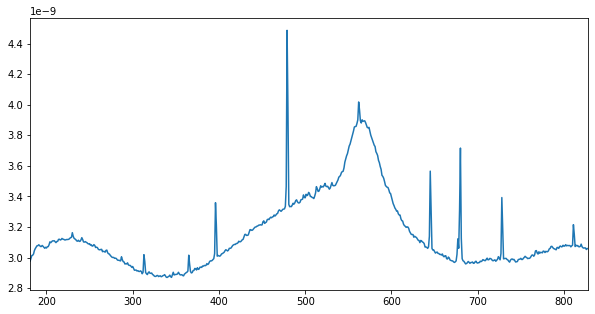

In [11]:
# Plot the row using the column range selected above
sky_row_series.plot(figsize=(10,5))

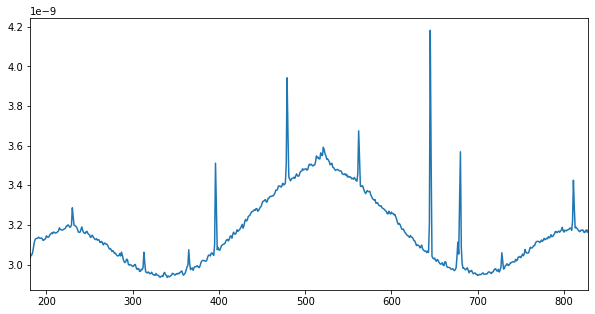

In [12]:
ref_row_series.plot(figsize=(10,5))

In [13]:
# Put the selected row data in a numpy array
sky_row_array = sky_row_series.to_numpy()
ref_row_array = ref_row_series.to_numpy()

In [14]:
ref_row_array = ref_row_array.astype('float64')

In [15]:
# Maybe I can 'smoov' dis janke, yo
ref_row_smoov = smooth(ref_row_array,window = 'blackman',window_len=21)

In [16]:
# Try the EWMA
ref_row_ewma = numpy_ewma_vectorized_v2(ref_row_array,30)

In [17]:
# Define the filter requirements
T = 15.0         # Sample Period
fs = 90.0       # sample rate, Hz
#cutoff = 1.4      # desired cutoff frequency of the filter, Hz
cutoff = 1.4
order = 2

nyq = 0.5 * fs  # Nyquist Frequency
n = int(T * fs) # total number of samples

In [18]:
# Filter the data, and plot both the original and filtered signals
#ref_row_baseline = butter_lowpass_filter(ref_row_smoov, cutoff, fs, order)
ref_row_baseline = butter_lowpass_filter(ref_row_ewma, cutoff, fs, order)


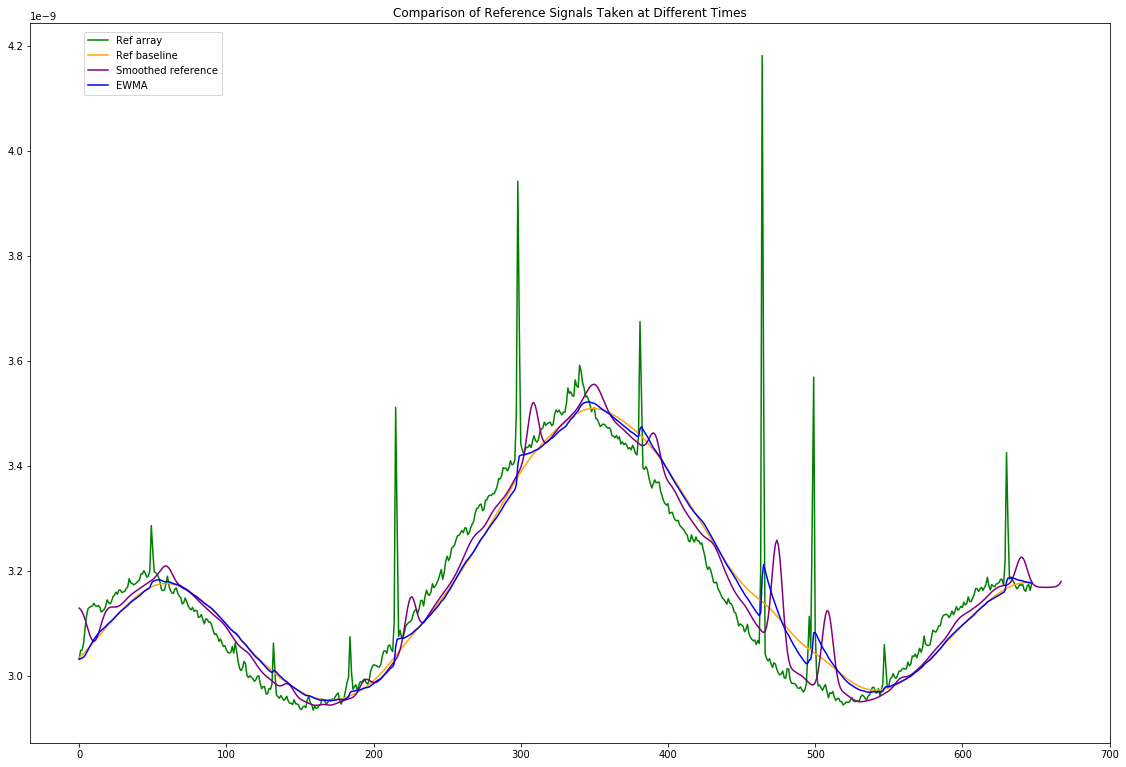

In [19]:
# Try to plot the baseline with the array
fig = plt.figure(figsize=(15,10))

ax=fig.add_axes([0,0,1,1],title = "Comparison of Reference Signals Taken at Different Times")

#ax.plot(sky_row_array,label='Sky array', color='blue')
ax.plot(ref_row_array,label='Ref array', color='green')
ax.plot(ref_row_baseline,label='Ref baseline', color='orange')
ax.plot(ref_row_smoov,label='Smoothed reference', color='purple')
ax.plot(ref_row_ewma,label='EWMA', color='blue')

ax.legend(loc=(0.05,0.9)) # use a location code

In [20]:
# Now do baseline subtraction and replot
# Looks like the smmoth function increased the array size - why?
#diff_array = sky_row_array - ref_row_baseline[:-20]
diff_array = sky_row_array - ref_row_baseline


Text(0.5, 1.0, 'Difference')

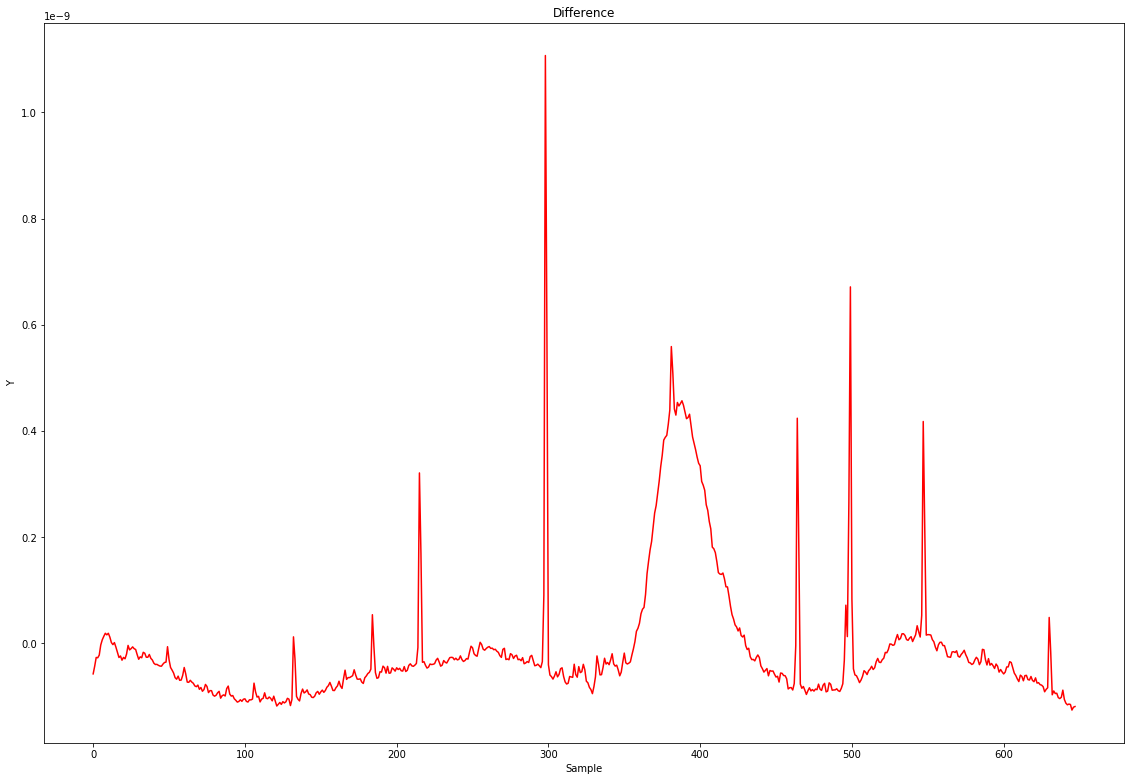

In [21]:
# Object oriented method
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0,0,1.0,1.0])

axes.plot(diff_array,color='red')
axes.set_xlabel('Sample')
axes.set_ylabel('Y')
axes.set_title('Difference')

I think I'm on the right track with this, but I need a more robust despiking algorithm to get rid of all of those
spikes before low-pass filtering.